In [ ]:
# Проверка на тестовом датасете

In [97]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.externals import joblib
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.metrics import confusion_matrix

import project_module

In [86]:
reload(project_module)

<module 'project_module' from 'project_module.py'>

Загрузка данных теста

In [27]:
# Определим ОС, подготовимся к загрузке
OSTYPE = !uname
if OSTYPE == ['Linux']:
     OSTYPE = 'Linux'
else:
     OSTYPE = 'Windows'
        
source_list = None
current_dir = None
if OSTYPE == 'Linux':
    source_list = !find ./for_test/ -type f | sort
else:
    source_list = !dir "for_test/30s" /B /S
    current_dir = !echo %cd%
    current_dir = current_dir[0]

file_list = project_module.GetFilenameList(source_list, OSTYPE, current_dir)

In [87]:
# Загрузим данные
audio_data = project_module.LoadAudio(file_list, True, OSTYPE)

In [101]:
# И еще нужно загрузить метки
labels_df = pd.read_csv("models/labels.csv", index_col=0)
labels = labels_df.iloc[:, 0].to_dict()
labels_list = labels_df.index.values

In [109]:
# Подготовим датасет
X_test, y_test = project_module.PrepareDataForModel(audio_data, labels)
X_test_nn, y_test_nn = project_module.PrepareDataForModel(audio_data, labels, normalize=False)

Загрузка моделей

In [108]:
# Загрузим модели
model_pcasvc = joblib.load('models/pcasvc.pkl') 
model_lda = joblib.load('models/lda.pkl')
model_pcasvc_nn = joblib.load('models/pcasvc_nn.pkl') 
model_lda_nn = joblib.load('models/lda_nn.pkl')

** Момент истины - тест! **

* Нормализованные модели

In [99]:
plt.rcParams["axes.grid"] = False

In [126]:
def PredictAndShow(model, X, y, name):
    y_pred = model.predict(X)
    print "Accuracy", accuracy_score(y_true=y, y_pred=y_pred)

    cnf_matrix = confusion_matrix(y, y_pred)
    plt.figure()
    project_module.PlotConfusionMatrix(cnf_matrix, classes=labels_list, normalize=False,  title=name)
    plt.show()

Accuracy 0.395833333333
Confusion matrix, without normalization
[[4 0 1 2 1 0 0 0 0 2]
 [0 4 1 0 0 5 0 0 0 0]
 [1 0 2 0 1 0 0 0 0 5]
 [0 0 0 6 1 0 1 0 1 1]
 [0 0 3 2 2 0 0 0 3 1]
 [0 1 2 1 1 1 0 1 0 3]
 [2 0 0 0 0 0 6 0 0 2]
 [1 0 0 2 0 0 0 5 1 1]
 [2 0 0 0 2 0 0 0 6 0]
 [1 0 1 0 1 0 0 0 1 2]]


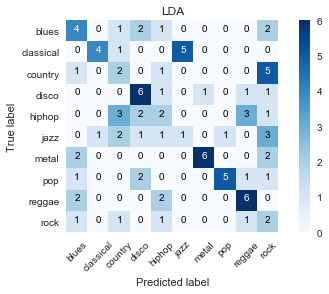

In [127]:
PredictAndShow(model_lda, X_test, y_test, "LDA")

Вероятностная классификация

In [166]:
#Минус - поменять порядок
y_proba = model_lda.predict_proba(X_test)
arg_sort = np.argsort(-y_proba)

count_first3 = 0
for i, sample in enumerate(arg_sort):
    position = np.where(sample == y_test[i])[0][0]
    if (position < 3):
        count_first3 += 1
        
# % треков, где нужный жанр находится среди первых 3х предложенных
print float(count_first3)/X_test.shape[0]

0.666666666667


In [176]:
# Вывод 3х предложенных жанров для 1ой песни
print "Скорее всего, это ", labels_df.iloc[arg_sort[0, 0]].name
print "но это еще может быть", labels_df.iloc[arg_sort[0, 1]].name, "или", labels_df.iloc[arg_sort[0, 2]].name

Скорее всего, это  jazz
но это еще может быть rock или blues


Accuracy 0.4375
Confusion matrix, without normalization
[[2 0 4 1 1 0 0 0 1 1]
 [0 8 0 0 0 0 0 0 0 2]
 [0 0 7 2 0 0 0 0 0 0]
 [0 0 2 5 1 0 0 0 1 1]
 [0 0 3 0 4 0 0 0 4 0]
 [0 0 2 2 1 3 0 0 1 1]
 [1 0 0 1 0 0 7 0 0 1]
 [1 0 3 5 0 0 0 1 0 0]
 [0 0 1 3 1 1 0 0 4 0]
 [0 0 1 1 0 0 2 0 1 1]]


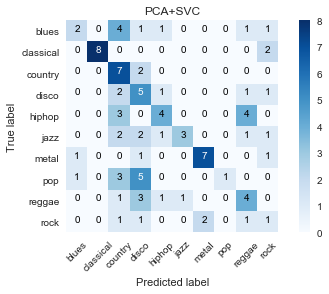

In [128]:
PredictAndShow(model_pcasvc, X_test, y_test, "PCA+SVC")

##### Мы возьмем LDA, поскольку в нем есть вероятностная классификация, что позволит несколько сгладить недостатки классификатора

* Ненормализованные модели (на всякий случай)

Accuracy 0.15625
Confusion matrix, without normalization
[[0 0 0 0 5 0 0 5 0 0]
 [0 4 0 0 1 0 0 5 0 0]
 [0 0 0 0 2 0 0 7 0 0]
 [0 0 0 0 2 0 0 8 0 0]
 [0 0 0 0 2 0 0 9 0 0]
 [0 0 0 0 2 0 0 8 0 0]
 [0 0 0 0 9 0 0 1 0 0]
 [0 0 0 0 1 0 0 9 0 0]
 [0 0 0 0 3 0 0 7 0 0]
 [0 0 0 0 2 0 0 4 0 0]]


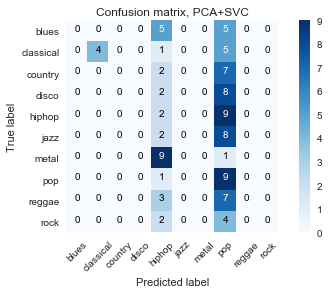

In [115]:
PredictAndShow(model_lda_nn, X_test_nn, y_test_nn)

Accuracy 0.0833333333333
Confusion matrix, without normalization
[[0 1 0 0 0 9 0 0 0 0]
 [0 0 0 0 3 7 0 0 0 0]
 [0 1 0 0 3 5 0 0 0 0]
 [0 3 0 0 3 4 0 0 0 0]
 [0 6 0 0 3 2 0 0 0 0]
 [0 4 0 0 1 5 0 0 0 0]
 [0 8 0 0 1 1 0 0 0 0]
 [0 4 0 0 1 5 0 0 0 0]
 [0 4 0 0 3 3 0 0 0 0]
 [0 2 0 0 0 4 0 0 0 0]]


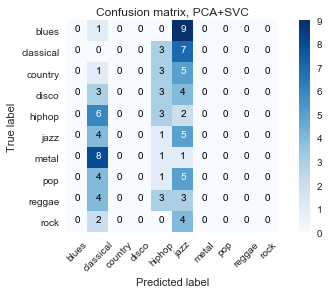

In [113]:
PredictAndShow(model_pcasvc_nn, X_test_nn, y_test_nn)

** Классификация полных песен **

In [ ]:
source_list = !dir "for_test/30s" /B /S
    current_dir = !echo %cd%
    current_dir = current_dir[0]

file_list = project_module.GetFilenameList(source_list, OSTYPE, current_dir)

In [188]:
np.linspace(0, 100, num=10, dtype=int)

array([  0,  11,  22,  33,  44,  55,  66,  77,  88, 100])